In this lab we will go over over basic stochastic optimization and uses in pytorch



(1) Setup the MNIST dataloaders for both the training (and  now as well test) set as in Lab 1 part 2. You do not need to iterate through the dataloaders, these will be used in the rest of the lab. 


In [ ]:
#This cell does not require outputing anything but is setup for subsequent cells
import torch
from torch import nn
from torchvision import transforms,datasets
from torch.utils import data
from torch.nn import functional as F
from matplotlib import pyplot as plt
import math


transform=transforms.Compose([
        transforms.ToTensor()
        ])

train_batch_size = 256
test_batch_size = 256

# load MNIST train and test sets
mnist_train = datasets.MNIST(root='.',
                             train=True,
                             download=True,
                              transform=transform)
mnist_test = datasets.MNIST(root='.',
                            train=False,
                            download=True,
                            transform=transform)

# initialize dataloaders for MNIST train and test sets
train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)
test_dataloader = data.DataLoader(mnist_test,batch_size=test_batch_size,drop_last=True)

(2) Consider your work from [Lab 1 part 2 (2)]. Modify the neural network as follows. The hidden outputs should be size 100 in both hidden layers and the activations should be relu. Modify the final layer to output 10 values instead of 1. 

Your code should implement $f(x) = W_2\rho(W_1\rho(W_0x+b_0)+b_1)+b_2$ with $f: R^{786}-> R^{10}$ and $\rho = relu$

Initialize the weights  using a variant of xavier intialization $w_{ij} \sim N(0,\frac{1}{\sqrt{n_i}})$ where $n_i$ is the size of the layer input. Initialize the biases as 0. Write a helper function to perform this initialization for subsequent parts of this lab

In [ ]:
import torch

# Target device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Initialize and track the parameters using a list or dictionary
h1_size = 50
h2_size = 50
param_dict = {
    "W0": torch.rand(784, h1_size)*2-1,
    "b0": torch.rand(h1_size)*2-1, 
    "W1": torch.rand(h1_size, h2_size)*2-1,
    "b1": torch.rand(h2_size)*2-1,
    "W2": torch.rand(h2_size,10)*2-1,
    "b2": torch.rand(10)*2-1,
    }

for name, param in param_dict.items():
    param_dict[name] = param.to(device)
    param.requires_grad=True

## Define the network
def my_nn(input, param_dict):
    r"""Performs a single forward pass of a Neural Network with the given 
    parameters in param_dict.

    Args:
        input (torch.tensor): Batch of images of shape (B, H, W), where B is 
            the number of input samples,and H and W are the image height and 
            width respectively.
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#" and "b#" where # is the layer number.

    Returns:
        torch.tensor: Neural network output of shape (B, )
    """


    x = input.view(-1 , 28*28) 

    # layer 1
    x = torch.relu_(x @ param_dict['W0'] + param_dict['b0'])

    # layer 2
    x = torch.relu_(x @ param_dict['W1'] + param_dict['b1'])

    # output 
    x = x @ param_dict['W2']  + param_dict['b2']

    return x


def initialize_nn(param_dict):
    """Takes a dictionary with existing torch tensors 
        and re-initializes them using xavier initialization
    """
    for name, param in param_dict.items():
        param_dict[name] = torch.zeros_like(param)
        if "W" in name:
            param_dict[name] = param_dict[name].normal_(0,1/math.sqrt(param.size(0)))
        # turn on parameter gradients for parameters, and move them to device
        param_dict[name] = param_dict[name].to(device)
        param_dict[name].requires_grad = True

initialize_nn(param_dict)

We will evaluate the cross entropy loss and average accuracy on this randomly initialized dataset. Use the torch.nn.functional.cross_entropy() function to compute the loss  $\frac{1}{N}\sum_i^N CrossEntropy(f(x_i),y_i)$ and accuracy. Your accuracy should be close to $10\%$ as the network has random weights. Note the pytorch cross_entropy function already applies the softmax operator so you do not need to apply this just feed the model output directly  



In [ ]:
# check if GPU is available or not
cuda = torch.cuda.is_available()

def test(test_dataloader):
    loss = 0
    accuracy = 0


    for data, target in test_dataloader:
        #move to GPU if available
        if cuda:
            data, target = data.to('cuda'), target.to('cuda')

        #compute model output
        output = my_nn(data,param_dict)
        #comptue accuracy for minibatch
        prediction = output.argmax(1)
        accuracy += sum(prediction == target).item()/test_batch_size
        #compute loss for minibatch
        loss += F.cross_entropy(output,target).item()
    #aggregate loss and accuracy for all test data
    print(f'test loss: {loss/len(test_dataloader):4f}')
    print(f'test accuracy: {accuracy/len(test_dataloader)*100:.2f}%')

test(test_dataloader)

test loss: 2.322439
test accuracy: 8.65%


(3) (a) Without any use of the torch.optim package implement from scratch mini-batch Stochastic Gradient Descent training to minimize the loss  $\frac{1}{N}\sum_i^N CrossEntropy(f(x_i),y_i)$ over the MNIST dataset. Use a minibatch size of 128 and a learning rate of 0.01 and run training for 20 epochs.  

Store the losses and training of each minibatch and plot each of these (with iterations (not epochs) as the x-axis). You can optionally smooth out these plots over 20-100 iteration window of your choosing to make them cleaner to read. Compute and report the final test accuracy as well at the end of the 20 epochs. 

You should end up with 2 plots and a final test accuracy. 


 epoch 0: train loss 1.6749- train accuracy 55.79%
 epoch 1: train loss 1.1717- train accuracy 69.47%
 epoch 2: train loss 0.9334- train accuracy 75.47%
 epoch 3: train loss 0.7970- train accuracy 78.84%
 epoch 4: train loss 0.7078- train accuracy 81.06%
 epoch 5: train loss 0.6443- train accuracy 82.65%
 epoch 6: train loss 0.5963- train accuracy 83.86%
 epoch 7: train loss 0.5585- train accuracy 84.81%
 epoch 8: train loss 0.5278- train accuracy 85.60%
 epoch 9: train loss 0.5022- train accuracy 86.25%
 epoch 10: train loss 0.4803- train accuracy 86.81%
 epoch 11: train loss 0.4614- train accuracy 87.30%
 epoch 12: train loss 0.4448- train accuracy 87.74%
 epoch 13: train loss 0.4300- train accuracy 88.13%
 epoch 14: train loss 0.4167- train accuracy 88.48%
 epoch 15: train loss 0.4047- train accuracy 88.80%
 epoch 16: train loss 0.3937- train accuracy 89.09%
 epoch 17: train loss 0.3836- train accuracy 89.36%
 epoch 18: train loss 0.3743- train accuracy 89.61%
 epoch 19: train loss 

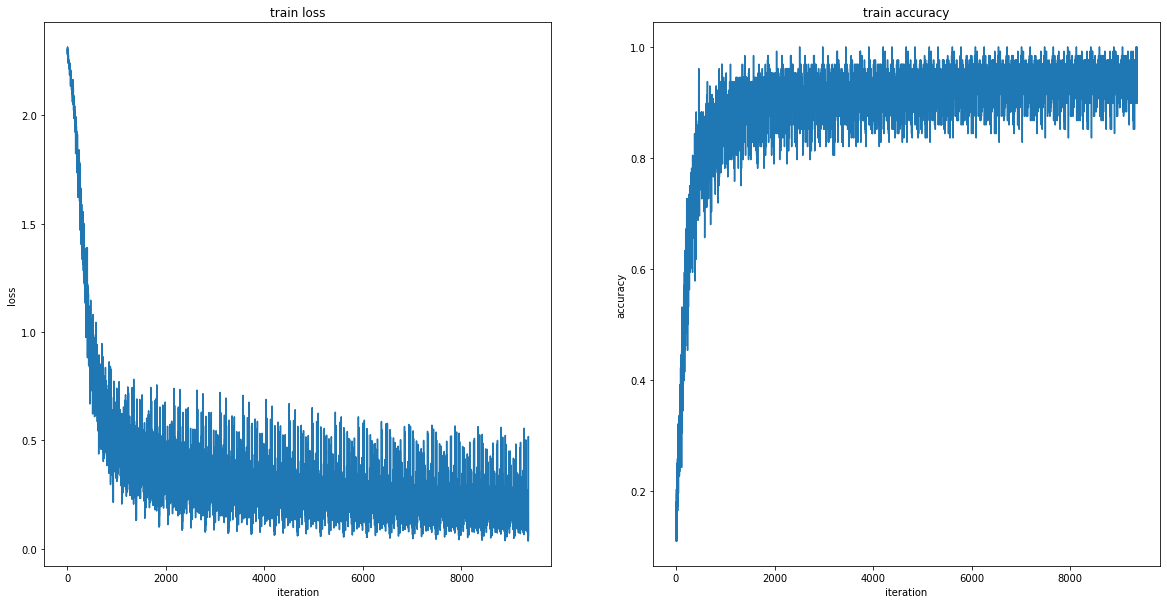

In [ ]:
import torch
from torch.utils import data


#reinitialize your network to random!
initialize_nn(param_dict)

# Training hyper parameters
train_batch_size = 128
lr = 0.01
n_epochs = 20

# reinitialize dataloader for MNIST train set
train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)

train_losses = [] # use to append the avg loss for each minibatch 
train_accs = [] # use to append the avg acc of minibatch

alpha=0.01
#iterate over the minibatches
for epoch in range(n_epochs):
    for data,target in train_dataloader:
      
        #move to GPU if available
        data, target = data.to(device), target.to(device)

        #compute model output
        output = my_nn(data,param_dict)
        #compute the gradient for the minibatch
        loss = F.cross_entropy(output,target)
        loss.backward()
        # track training loss and accuracy
        train_losses.append(loss.item())
        prediction = output.argmax(1)
        train_accs.append(sum(prediction == target).item()/train_batch_size)
        #update the model parameters by w_t-alpha*\grad_{w_t}(f(w_t))
        for (name,param) in param_dict.items():
            with torch.no_grad():
                param_dict[name] -= alpha * param_dict[name].grad
            if param.grad is not None:
                param_dict[name].grad.detach_()
                param_dict[name].grad.zero_()
    # print training progress
    print(f' epoch {epoch}: train loss {sum(train_losses)/(len(train_dataloader)*(epoch+1)):.4f}- train accuracy {sum(train_accs)/(len(train_dataloader)*(epoch+1))*100:.2f}%')
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
#Evaluate on the test set
test(test_dataloader)
# save train loss and accuracy for further comparison
train_loss_sgd = train_losses
train_accs_sgd = train_accs

(b) Modify the above code to perform minibatch SGD with momentum. Use a momentum of $\mu=0.9$ and learning rate $\alpha=0.01$. Use the following formulation of momentum: 

$g = \nabla_wCE(f(w_t,X),Y)$  gradient estimate with mini-batch

$v_{t+1} = \mu * v_t + g$ 

$w_{t+1} = w - \alpha*v_{t+1}$ 

Obtain the same plots as before and a final test accuracy

 epoch 0: train loss 0.5814- train accuracy 83.01%
 epoch 1: train loss 0.4167- train accuracy 87.84%
 epoch 2: train loss 0.3430- train accuracy 89.98%
 epoch 3: train loss 0.2976- train accuracy 91.31%
 epoch 4: train loss 0.2655- train accuracy 92.25%
 epoch 5: train loss 0.2412- train accuracy 92.96%
 epoch 6: train loss 0.2218- train accuracy 93.53%
 epoch 7: train loss 0.2059- train accuracy 93.99%
 epoch 8: train loss 0.1926- train accuracy 94.39%
 epoch 9: train loss 0.1812- train accuracy 94.72%
 epoch 10: train loss 0.1712- train accuracy 95.02%
 epoch 11: train loss 0.1625- train accuracy 95.27%
 epoch 12: train loss 0.1547- train accuracy 95.50%
 epoch 13: train loss 0.1477- train accuracy 95.70%
 epoch 14: train loss 0.1413- train accuracy 95.89%
 epoch 15: train loss 0.1356- train accuracy 96.06%
 epoch 16: train loss 0.1303- train accuracy 96.22%
 epoch 17: train loss 0.1254- train accuracy 96.36%
 epoch 18: train loss 0.1209- train accuracy 96.50%
 epoch 19: train loss 

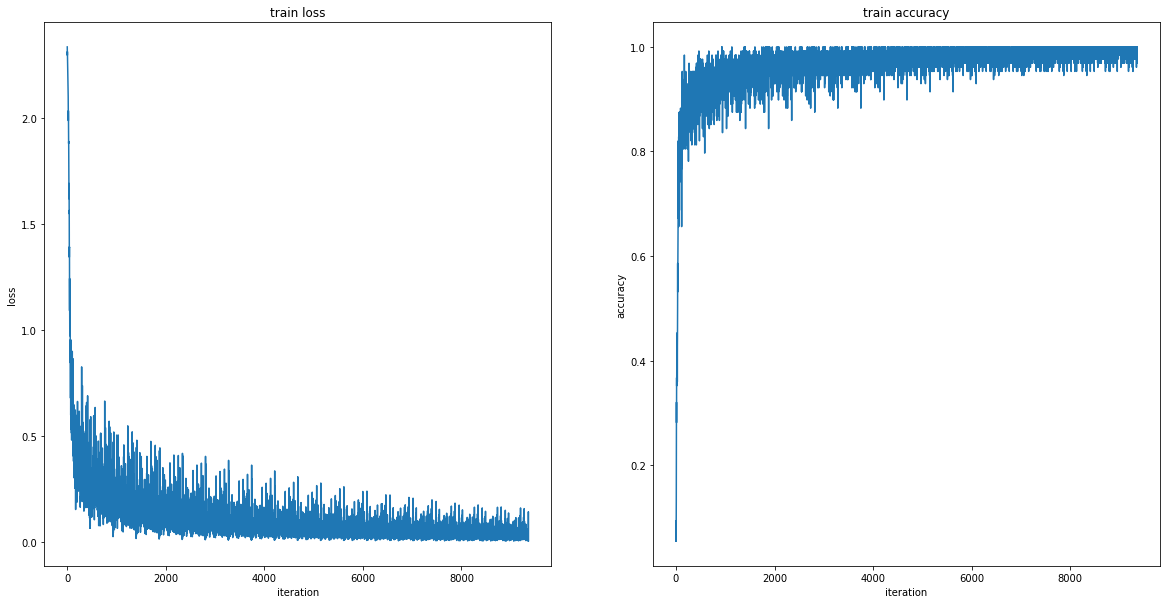

In [ ]:
#reinitialize your network to random!
initialize_nn(param_dict)

train_losses = [] # use to append the avg loss for each minibatch 
train_accs = [] # use to append the avg acc of minibatch

# learning rate and momentum
alpha=0.01
mu=0.9

# initialize velocity for every parameter
v={}
for (name,param) in param_dict.items():
    v[name] = torch.zeros_like(param)

#iterate over the minibatches
for epoch in range(n_epochs):
    for data,target in train_dataloader:
        #move to GPU if available
        #move to GPU if available
        data, target = data.to(device), target.to(device)

        #compute model output
        output = my_nn(data,param_dict)
        #compute the gradient for the minibatch
        loss = F.cross_entropy(output,target)
        loss.backward()
        # track training loss and accuracy
        train_losses.append(loss.item())
        prediction = output.argmax(1)
        train_accs.append(sum(prediction == target).item()/train_batch_size)
        #update the model parameters by w_t-alpha*\grad_{w_t}(f(w_t))
        for (name,param) in param_dict.items():
            with torch.no_grad():
                v[name] = mu*v[name] + param_dict[name].grad 
                param_dict[name] -= alpha * v[name]
            if param.grad is not None:
                param_dict[name].grad.detach_()
                param_dict[name].grad.zero_()
    # print training progress
    print(f' epoch {epoch}: train loss {sum(train_losses)/(len(train_dataloader)*(epoch+1)):.4f}- train accuracy {sum(train_accs)/(len(train_dataloader)*(epoch+1))*100:.2f}%')
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
#Evaluate on the test set
test(test_dataloader)
# save train loss and accuracy for further comparison
train_loss_mom = train_losses
train_accs_mom = train_accs

(4) Repeat (3) but now using the package torch.optim.SGD to perform SGD (a) and SGD with momentum (b). Use the same learning rate in the case of (a) and the same learning rate and momentum in the case of (b)


https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20sgd#torch.optim.SGD


Plot the same training curves and accuracy curves. Overlay this with their respective implementation from (3). Report the final accuracy.

You should end up with 4 plots (train acc,train loss)x(sgd, sgd+momentum) each containing two curves (your implementation from (3) and the torch.optim result). Due to random initialization and random training order you will not get identical results to (3) but the curves and final accuracies should end up relatively close. 


In [ ]:
#Answer for SGD
import torch
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha)

def train(train_dataloader,optimizer):
    train_losses = [] # use to append the avg loss for each minibatch 
    train_accs = [] # use to append the avg acc of minibatch
    #iterate over the minibatches
    for epoch in range(n_epochs):
        for data,target in train_dataloader:
            #move to GPU if available
            data, target = data.to(device), target.to(device)

            # set gradients to zero
            optimizer.zero_grad()
            #compute model output
            output = my_nn(data,param_dict)
            #compute the gradient for the minibatch
            loss = F.cross_entropy(output,target)
            loss.backward()
            # update weights
            optimizer.step()
            # track training loss and accuracy
            train_losses.append(loss.item())
            prediction = output.argmax(1)
            train_accs.append(sum(prediction == target).item()/train_batch_size)
            #update the model parameters by w_t-alpha*\grad_{w_t}(f(w_t))
        # print training progress
        print(f' epoch {epoch}: train loss {sum(train_losses)/(len(train_dataloader)*(epoch+1)):.4f}- train accuracy {sum(train_accs)/(len(train_dataloader)*(epoch+1))*100:.2f}%')
    return train_losses,train_accs

train_losses,train_accs = train(train_dataloader,optimizer)


 epoch 0: train loss 1.6960- train accuracy 55.95%
 epoch 1: train loss 1.1769- train accuracy 70.01%
 epoch 2: train loss 0.9318- train accuracy 76.01%
 epoch 3: train loss 0.7924- train accuracy 79.40%
 epoch 4: train loss 0.7017- train accuracy 81.60%
 epoch 5: train loss 0.6373- train accuracy 83.16%
 epoch 6: train loss 0.5888- train accuracy 84.35%
 epoch 7: train loss 0.5506- train accuracy 85.30%
 epoch 8: train loss 0.5195- train accuracy 86.06%
 epoch 9: train loss 0.4937- train accuracy 86.71%
 epoch 10: train loss 0.4718- train accuracy 87.27%
 epoch 11: train loss 0.4528- train accuracy 87.75%
 epoch 12: train loss 0.4362- train accuracy 88.17%
 epoch 13: train loss 0.4215- train accuracy 88.55%
 epoch 14: train loss 0.4083- train accuracy 88.89%
 epoch 15: train loss 0.3964- train accuracy 89.19%
 epoch 16: train loss 0.3856- train accuracy 89.47%
 epoch 17: train loss 0.3758- train accuracy 89.73%
 epoch 18: train loss 0.3667- train accuracy 89.96%
 epoch 19: train loss 

test loss: 0.197311
test accuracy: 94.18%


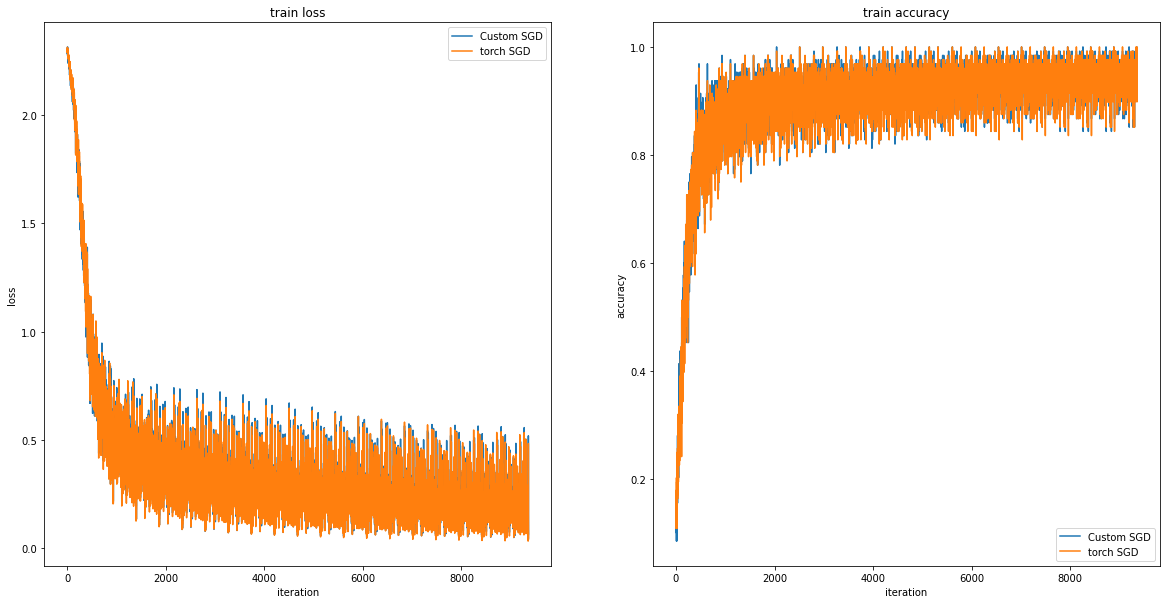

In [ ]:
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_loss_sgd,label='Custom SGD')
axs[0].plot(train_losses,label='torch SGD')
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accs,label='Custom SGD')
axs[1].plot(train_accs_sgd,label='torch SGD')
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
axs[1].legend()
#Evaluate on the test set
test(test_dataloader)

In [ ]:
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha, momentum=mu)

train_losses , train_accs = train(train_dataloader,optimizer)

 epoch 0: train loss 0.5679- train accuracy 83.43%
 epoch 1: train loss 0.4086- train accuracy 88.06%
 epoch 2: train loss 0.3386- train accuracy 90.10%
 epoch 3: train loss 0.2955- train accuracy 91.35%
 epoch 4: train loss 0.2648- train accuracy 92.24%
 epoch 5: train loss 0.2413- train accuracy 92.92%
 epoch 6: train loss 0.2225- train accuracy 93.46%
 epoch 7: train loss 0.2070- train accuracy 93.91%
 epoch 8: train loss 0.1939- train accuracy 94.30%
 epoch 9: train loss 0.1827- train accuracy 94.63%
 epoch 10: train loss 0.1729- train accuracy 94.91%
 epoch 11: train loss 0.1642- train accuracy 95.17%
 epoch 12: train loss 0.1566- train accuracy 95.39%
 epoch 13: train loss 0.1497- train accuracy 95.60%
 epoch 14: train loss 0.1434- train accuracy 95.78%
 epoch 15: train loss 0.1378- train accuracy 95.95%
 epoch 16: train loss 0.1326- train accuracy 96.11%
 epoch 17: train loss 0.1278- train accuracy 96.25%
 epoch 18: train loss 0.1233- train accuracy 96.39%
 epoch 19: train loss 

test loss: 0.106430
test accuracy: 96.88%


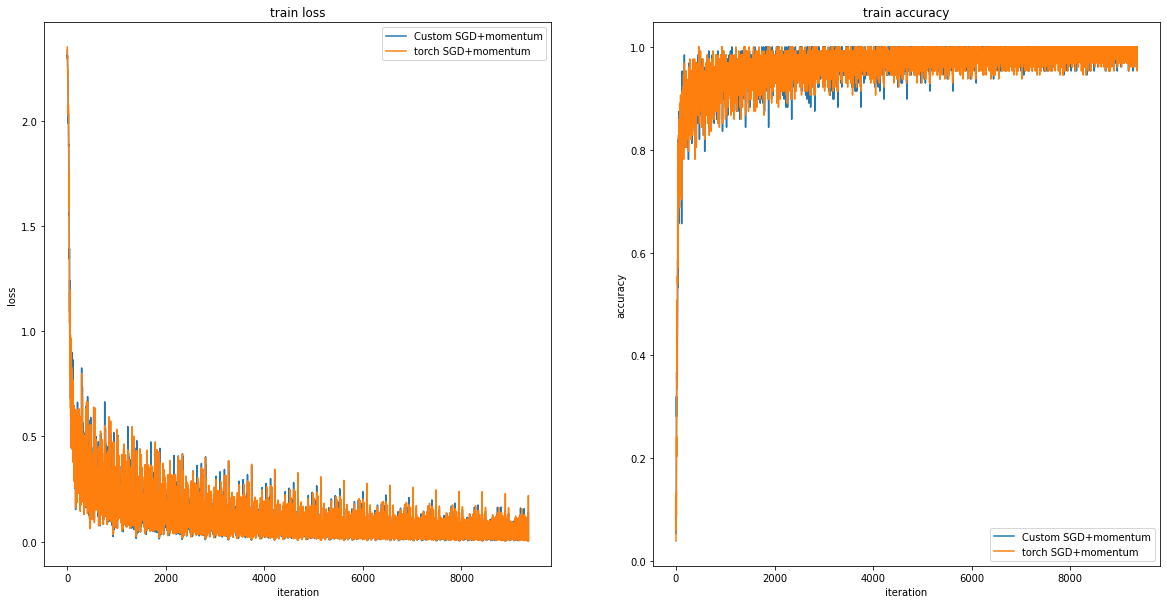

In [ ]:
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_loss_mom,label='Custom SGD+momentum')
axs[0].plot(train_losses,label='torch SGD+momentum')
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accs_mom,label='Custom SGD+momentum')
axs[1].plot(train_accs,label='torch SGD+momentum')
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
axs[1].legend()
#Evaluate on the test set
test(test_dataloader)